<a href="https://colab.research.google.com/github/zlnga1001/Interpretability-machine-learning-model-in-stock-market/blob/main/Nv_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [ ]:
!pip install --upgrade numpy

2.Data Loading

In [ ]:
# load dataset
from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_csv('drive/Shared drives/23SummerProject/Code/Apple/AAPL-4.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

3. Exploratory Data Analysis

In [ ]:
# Shape
dataset.shape

(2768, 7)

In [ ]:
# peak at data
set_option('display.width', 100)
dataset.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2763,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2764,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2765,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674019,85438400
2766,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700
2767,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200


In [ ]:
# describe data
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2.768000e+03
mean,58.609123,59.266503,57.962710,58.637391,56.583387,2.035526e+08
std,47.957848,48.585227,47.342160,47.986391,48.428995,1.717732e+08
min,13.856071,14.271429,13.753571,13.947500,12.029552,3.519590e+07
25%,24.148750,24.371519,23.916697,24.163751,21.891779,9.501720e+07
50%,37.632500,38.088751,37.301250,37.661249,35.725656,1.395220e+08
75%,77.147501,78.218752,76.302502,77.390627,75.656924,2.480580e+08
max,182.630005,182.940002,179.119995,182.009995,180.434296,1.506120e+09


4.Data Prepare

In [ ]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [ ]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [ ]:
dataset=dataset.drop(columns=['Date'])

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
import talib

--2023-06-28 18:54:51--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-28 18:54:52--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-28 18:54:52--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

 4.1 Preparing the data for classification

 We attach a label to each movement:

1 if the signal is that short term price will go up as compared to the long term.

0 if the signal is that short term price will go down as compared to the long term.

In [ ]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
#dataset['short_mavg'] = dataset['Adj Close'].rolling(window=10, min_periods=1, center=False).mean()
dataset['short_mavg'] = talib.SMA(dataset['Adj Close'], timeperiod=50)
# Create long simple moving average over the long window
#dataset['long_mavg'] = dataset['Adj Close'].rolling(window=60, min_periods=1, center=False).mean()
dataset['long_mavg'] = talib.SMA(dataset['Adj Close'], timeperiod=200)
# Create signals(1-buy,0-sell)
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [ ]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal
2763,130.919998,132.419998,129.639999,131.860001,131.477127,63814900,143.640676,151.326928,0.0
2764,131.380005,131.410004,128.720001,130.029999,129.652435,69007800,143.478731,151.207261,0.0
2765,129.669998,131.029999,125.870003,126.040001,125.674019,85438400,143.156984,151.088100,0.0
2766,127.989998,130.479996,127.730003,129.610001,129.233658,75703700,142.879753,150.964552,0.0
2767,128.410004,129.949997,127.430000,129.929993,129.552719,77034200,142.606713,150.820266,0.0


4.2 Feature Engineering

In [ ]:
#!pip install --upgrade numpy

In [ ]:
#EMA
dataset['EMA12'] = talib.EMA(dataset['Adj Close'],timeperiod=12)
dataset['EMA26'] = talib.EMA(dataset['Adj Close'],timeperiod=26)
dataset['EMA50'] = talib.EMA(dataset['Adj Close'],timeperiod=50)
dataset['EMA100'] = talib.EMA(dataset['Adj Close'],timeperiod=100)
dataset['EMA200'] = talib.EMA(dataset['Adj Close'],timeperiod=200)

#ROC
dataset['ROC10'] = talib.ROC(dataset['Adj Close'],timeperiod=10)
dataset['ROC30'] = talib.ROC(dataset['Adj Close'],timeperiod=30)
dataset['ROC100'] = talib.ROC(dataset['Adj Close'],timeperiod=100)

#MOM
dataset['MOM10'] = talib.MOM(dataset['Adj Close'], timeperiod=10)
dataset['MOM30'] = talib.MOM(dataset['Adj Close'], timeperiod=30)

#RSI
dataset['RSI10'] = talib.RSI(dataset['Adj Close'],timeperiod=10)
dataset['RSI30'] = talib.RSI(dataset['Adj Close'],timeperiod=30)
dataset['RSI70'] = talib.RSI(dataset['Adj Close'],timeperiod=70)

##Stochastic osillator
# STOK. STOD
def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)


#Volatility Indicator Functions
#ATR
dataset['ATR14'] = talib.ATR(dataset['High'],dataset['Low'],dataset['Adj Close'],timeperiod=14)

#Volume Indicator Functions
#ADOSC - Chaikin A/D Oscillator
dataset['ADOSC'] = talib.ADOSC(dataset['High'],dataset['Low'],dataset['Adj Close'],dataset['Volume'], fastperiod=3, slowperiod=10)

In [ ]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA12,...,RSI30,RSI70,%K10,%D10,%K30,%D30,%K200,%D200,ATR14,ADOSC
2763,130.919998,132.419998,129.639999,131.860001,131.477127,63814900,143.640676,151.326928,0.0,136.369364,...,41.651351,45.380186,10.919832,16.754144,9.269321,14.200879,5.576444,8.186681,4.426397,-9.341213e+07
2764,131.380005,131.410004,128.720001,130.029999,129.652435,69007800,143.478731,151.207261,0.0,135.335990,...,40.644097,44.921848,6.164696,9.579300,5.267383,8.136703,2.574176,4.819571,4.307164,-8.228800e+07
2765,129.669998,131.029999,125.870003,126.040001,125.674019,85438400,143.156984,151.088100,0.0,133.849533,...,38.541840,43.940211,0.817691,5.967406,0.613269,5.049991,0.316334,2.822318,4.368080,-9.950648e+07
2766,127.989998,130.479996,127.730003,129.610001,129.233658,75703700,142.879753,150.964552,0.0,133.139399,...,41.349714,45.030545,23.477702,10.153363,13.939615,6.606756,6.959431,3.283314,4.399359,-9.525049e+07
2767,128.410004,129.949997,127.430000,129.929993,129.552719,77034200,142.606713,150.820266,0.0,132.587602,...,41.597127,45.127591,34.465137,19.586843,15.132281,9.895055,7.554876,4.943547,4.265119,-6.806768e+07


In [ ]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open','Close','short_mavg','long_mavg'], axis=1)

In [ ]:
dataset = dataset.dropna(axis=0)

In [ ]:
dataset.tail()

,Adj Close,Volume,signal,EMA12,EMA26,EMA50,EMA100,EMA200,ROC10,ROC30,...,RSI30,RSI70,%K10,%D10,%K30,%D30,%K200,%D200,ATR14,ADOSC
2763,131.477127,63814900,0.0,136.369364,140.013547,142.980001,146.408930,149.097294,-7.245350,-10.219912,...,41.651351,45.380186,10.919832,16.754144,9.269321,14.200879,5.576444,8.186681,4.426397,-9.341213e+07
2764,129.652435,69007800,0.0,135.335990,139.246057,142.457352,146.077119,148.903813,-10.007614,-13.139613,...,40.644097,44.921848,6.164696,9.579300,5.267383,8.136703,2.574176,4.819571,4.307164,-8.228800e+07
2765,125.674019,85438400,0.0,133.849533,138.240721,141.799182,145.673097,148.672671,-13.356710,-14.998652,...,38.541840,43.940211,0.817691,5.967406,0.613269,5.049991,0.316334,2.822318,4.368080,-9.950648e+07
2766,129.233658,75703700,0.0,133.139399,137.573531,141.306416,145.347563,148.479248,-9.496547,-13.616362,...,41.349714,45.030545,23.477702,10.153363,13.939615,6.606756,6.959431,3.283314,4.399359,-9.525049e+07
2767,129.552719,77034200,0.0,132.587602,136.979397,140.845487,145.034794,148.290924,-4.813195,-12.675584,...,41.597127,45.127591,34.465137,19.586843,15.132281,9.895055,7.554876,4.943547,4.265119,-6.806768e+07


4.3 data visualize

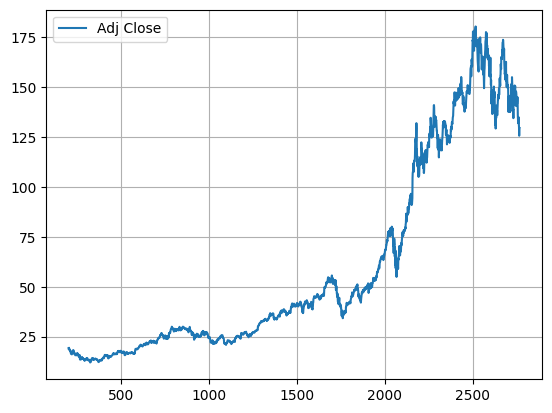

In [ ]:
dataset[['Adj Close']].plot(grid=True)
plt.show()

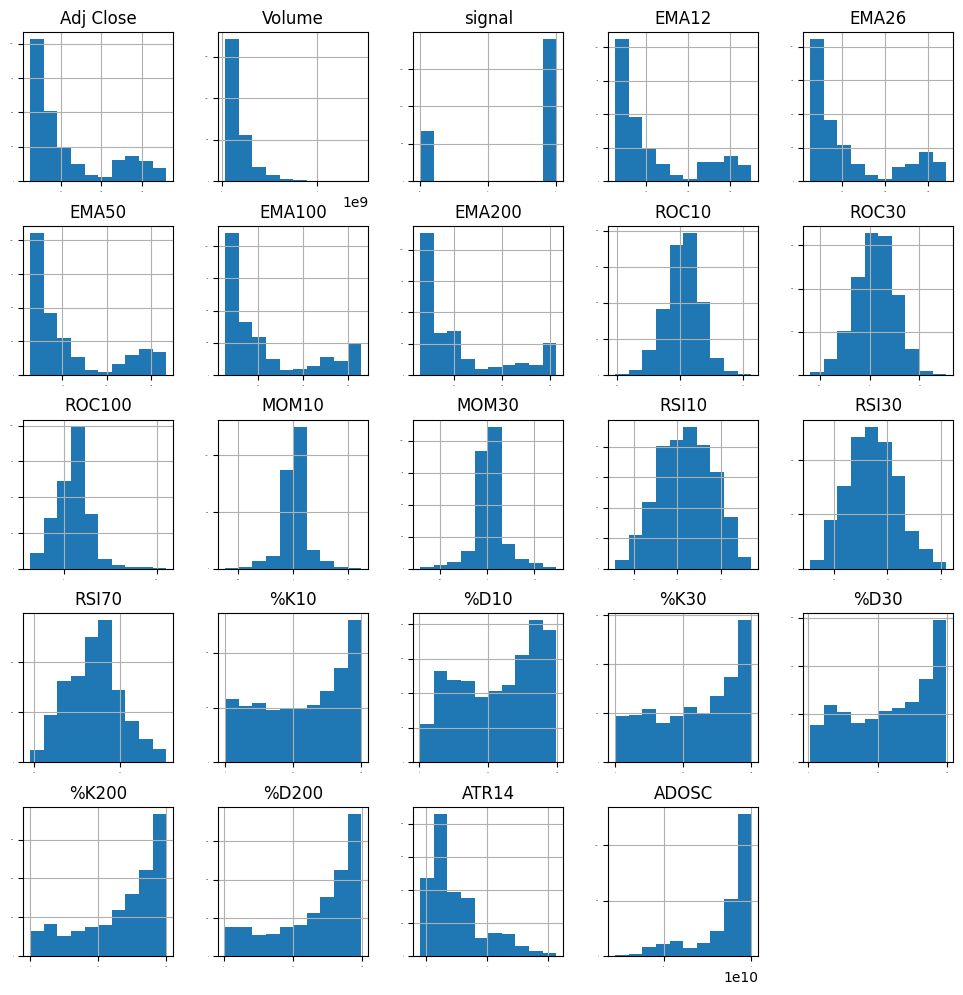

In [ ]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

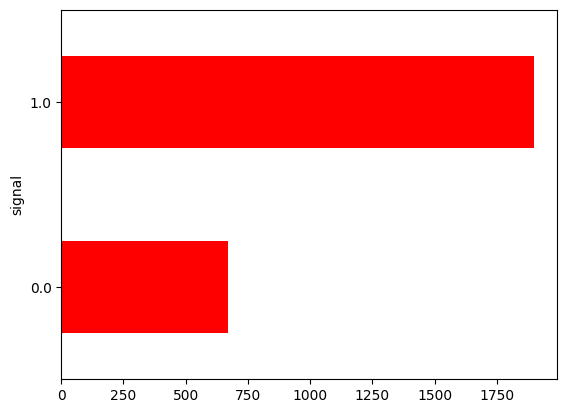

In [ ]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

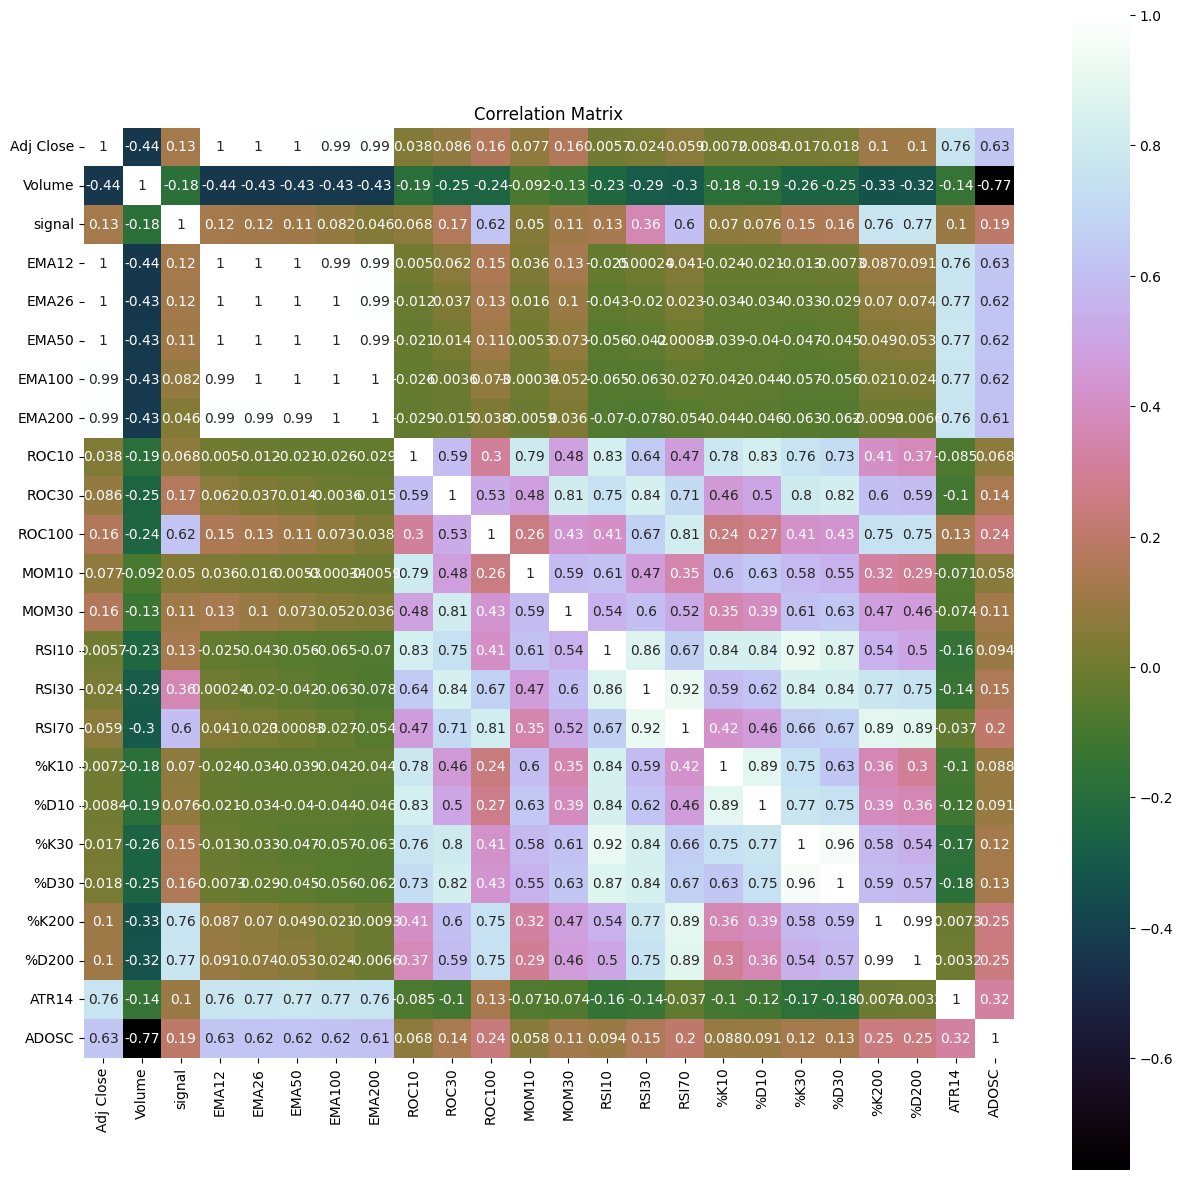

In [ ]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# 5. Evaluate Algorithms and Models

  5.1 Train Split Data
  We split the dataset into 80% training set and 20% test set.

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

5.2. Test Options and Evaluation Metrics

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

5.3.1 Models

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

K-folds cross validation

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.701885 (0.027368)
LDA: 0.975669 (0.014565)
KNN: 0.820294 (0.022408)
CART: 0.961525 (0.014986)
NB: 0.723791 (0.034278)
NN: 0.645799 (0.119421)
AB: 0.987334 (0.007303)
GBM: 0.987336 (0.006615)
RF: 0.993668 (0.004383)


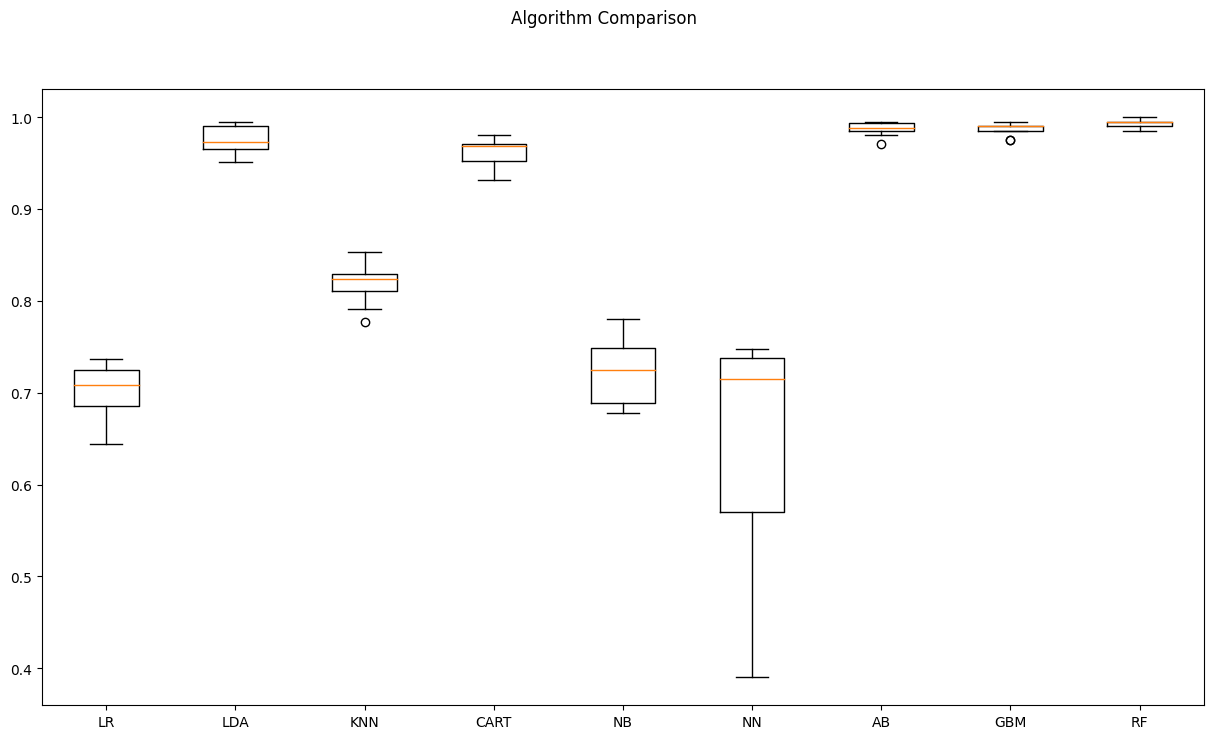

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [ ]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split.
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

'''
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=None, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.993185 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#8 0.975650 (0.006517) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.979548 (0.008067) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.992209 (0.008217) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.992212 (0.006236) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.978579 (0.010681) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.979545 (0.006445) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.989780 (0.007362) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.993185 (0.004462) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


7. Finalize Models

Finalizing the model with best parameters found during tuning step.

7.1 Results on the Test Dataset

In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression()
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9941634241245136
[[110   3]
 [  0 401]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       113
         1.0       0.99      1.00      1.00       401

    accuracy                           0.99       514
   macro avg       1.00      0.99      0.99       514
weighted avg       0.99      0.99      0.99       514



<Axes: xlabel='Predicted', ylabel='Actual'>

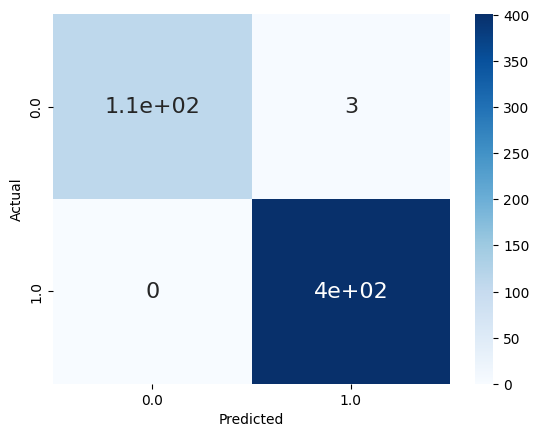

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

7.2. Variable Intuition/Feature Importance

Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

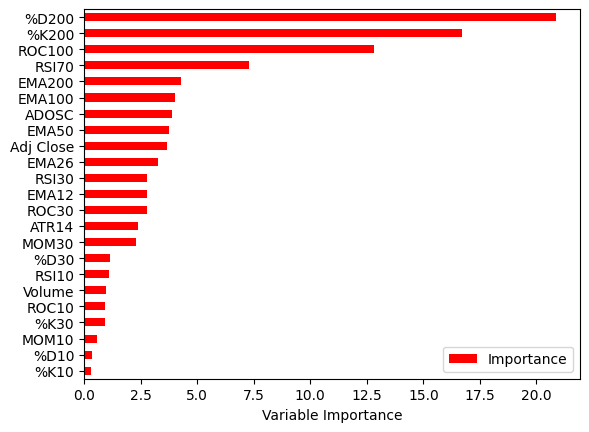

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

8.Backtesting Results

<Axes: >

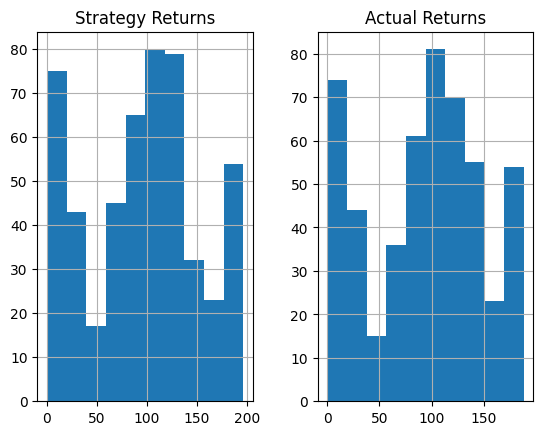

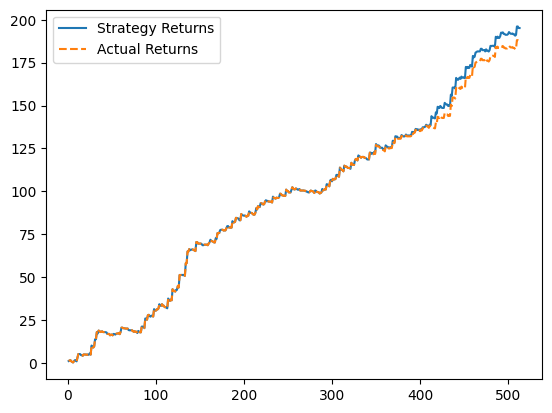

In [ ]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Adj Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot(style=['-','--'])

In [ ]:
backtestdata.head()

,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
0,1329,1.0,1.0,NaN,NaN,NaN
1,2047,1.0,1.0,1.196534,1.196534,1.196534
2,2149,1.0,1.0,0.323009,0.323009,0.323009
3,2168,1.0,1.0,0.170370,0.170370,0.170370
4,1477,1.0,1.0,-0.640651,-0.640651,-0.640651


In [ ]:
backtestdata.tail()

,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
509,760,1.0,1.0,0.493275,0.493275,0.493275
510,2402,1.0,1.0,4.862647,4.862647,4.862647
511,2464,1.0,1.0,0.009419,0.009419,0.009419
512,334,0.0,0.0,-0.904454,-0.904454,-0.904454
513,2709,0.0,0.0,9.060882,0.000000,0.000000


In [ ]:
pip install lime

In [ ]:
pip install numpy

In [ ]:

import numpy as np
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Buy', 'Sell'],
    mode='classification')


In [ ]:
import lime #import LIME library
from lime import lime_tabular #import lime tabular modeule from LIME library
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train), #trading_data parameter takes the trading data as numpy array (x_train is converted to numpy)
    feature_names=X_train.columns, #The feature_names parameter expects a list of feature names for the input data. X_train.columns provides the column names of the X_train DataFrame.
    class_names=['Buy', 'Sell'], #classes are Buy or Sell
    mode='classification') #classication task, hence the mode

In [ ]:
exp = explainer.explain_instance(data_row = X_validation.iloc[52],predict_fn = model.predict_proba)

exp.show_in_notebook(show_table=True)

In [ ]:
pip install eli5


In [ ]:
pip install xgboost

In [ ]:
pip install keras

In [ ]:
pip install tensorflow

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0


In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y = subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation =\
train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'Feature Importances')

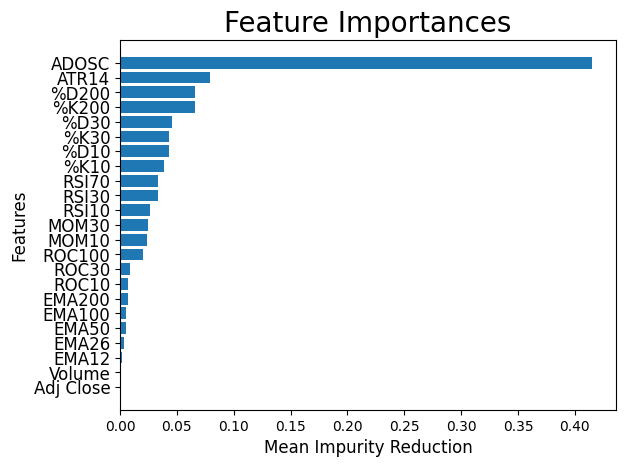

In [ ]:
#Tree-based Feature Importance
tree_feature = pd.Series(xgb.feature_importances_, X_train.columns).sort_values(ascending = True)
plt.barh(X_train.columns, tree_feature)
plt.xlabel('Mean Impurity Reduction', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Feature Importances', fontsize = 20)

In [ ]:
#Model Explainability/Interpretation with Eli5

In [ ]:
#Importing the module
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
#Permutation Importance
perm = PermutationImportance(xgb, scoring = 'accuracy' ,random_state=101).fit(X_validation, Y_validation)
show_weights(perm, feature_names = list(X_validation.columns))

Weight,Feature
0.0957 ± 0.0126,%D200
0.0436 ± 0.0117,ROC100
0.0253 ± 0.0078,ADOSC
0.0233 ± 0.0055,EMA50
0.0163 ± 0.0019,%K200
0.0101 ± 0.0075,ROC30
0.0054 ± 0.0067,%D30
0.0047 ± 0.0031,ATR14
0.0047 ± 0.0019,RSI30
0.0047 ± 0.0019,EMA100


In [ ]:
#Tree Feature Importance via eli5
show_weights(xgb, importance_type = 'gain')

Weight,Feature
0.4155,%D200
0.0789,MOM30
0.0663,%D30
0.0658,EMA26
0.0457,ROC100
0.0433,RSI30
0.0432,%K200
0.0387,ADOSC
0.0338,EMA50
0.0333,ATR14


In [ ]:
#Taking an example of test data
from eli5 import show_prediction
show_prediction(xgb, X_validation.iloc[1], show_feature_values=True)

In [ ]:
show_prediction(xgb, X_validation.iloc[0], show_feature_values=True)

In [ ]:
Y_pred = xgb.predict(X_validation)
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(Y_validation, Y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       113
         1.0       0.99      1.00      1.00       401

    accuracy                           0.99       514
   macro avg       0.99      0.99      0.99       514
weighted avg       0.99      0.99      0.99       514



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_validation, Y_pred)

array([[110,   3],
       [  1, 400]])